## Does the inclusion of cryptocurrency-based indicies extend the MV frontier of a well diversified equity investor?

In [64]:
import numpy as np
import pandas as pd
import scipy 
import scipy.optimize as opt
import matplotlib.pyplot as plt
import textwrap
import seaborn as sns

# Paramaters
rf = 0.019 # Risk-free rate 
periods_per_year = 260 # Number of trading days per year

To use own data --> requires one CSV with returns for benchmark. 
* One CSV with returns for additional returns that one would consider adding into the portfolio
* First column in both of these files need to be the date column

Importing benchmark & crypto portfolio created in data_grabbing.ipynb, creating the list of names of industry portfolios and names of cryptocurrency pairs to be put inside the optimizer

In [65]:
test_industry = pd.read_csv('../data/industry_returns.csv')
test_crypto = pd.read_csv('../data/crypto_returns.csv')
crypto = test_crypto.columns.values.tolist()[1:]

# Defining lists used later:
industry = test_industry.columns.values.tolist()[1:]
industry_and_crypto = industry + crypto

print(industry)
print(industry_and_crypto)

['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth ', 'Money', 'Other']
['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth ', 'Money', 'Other', 'BTC-USD', 'ETH-USD', 'XRP-USD']


Double check on dates of available data (excluding the weekend price data characteristic of cryptocurrency pairs)

In [66]:
# Convert the indices to sets
dates_in_industry = set(test_industry.index)
dates_in_crypto = set(test_crypto.index)

# Find dates that are only in crypto_returns
dates_only_in_crypto_returns = dates_in_crypto - dates_in_industry

# Convert to a sorted list for easier viewing or further processing
dates_only_in_crypto_returns = sorted(list(dates_only_in_crypto_returns))

# Print or inspect the dates
print(dates_only_in_crypto_returns)

[]


Creating the main dataframe consisting of all columns of ordinary returns from both .csv files joined based on the respective dates

In [67]:
ind_crypto = pd.merge(test_industry, test_crypto, on='Date') # this is an inner join --> only includes values that has dates in both df:s
ind_crypto = ind_crypto.set_index('Date')
ind_crypto

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other,BTC-USD,ETH-USD,XRP-USD
Date,,,,,,,,,,,,,,,
2017-11-10,0.0109,0.0041,0.0025,-0.0041,-0.0010,0.0034,-0.0029,-0.0062,0.0054,0.0037,0.0001,0.0015,-0.073554,-0.067411,-0.050600
2017-11-13,0.0027,0.0053,-0.0036,-0.0082,0.0054,-0.0007,-0.0084,0.0047,-0.0028,-0.0044,0.0045,-0.0050,-0.008862,0.058355,-0.014728
2017-11-14,0.0053,-0.0027,-0.0056,-0.0335,-0.0072,-0.0007,-0.0078,0.0116,0.0016,-0.0123,0.0029,-0.0058,0.011626,0.066037,0.031375
2017-11-15,-0.0040,-0.0083,-0.0061,-0.0131,-0.0132,-0.0063,0.0018,-0.0097,-0.0012,0.0049,0.0006,-0.0053,0.102444,-0.012659,0.014922
2017-11-16,0.0199,0.0258,0.0167,0.0073,0.0142,0.0219,0.0183,0.0037,0.0214,0.0201,0.0132,0.0182,0.076023,-0.007298,0.066450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-24,0.0105,0.0083,0.0097,-0.0046,0.0060,0.0104,0.0074,0.0131,0.0029,0.0088,-0.0008,0.0017,0.024641,0.010794,0.021325
2023-10-25,-0.0047,-0.0218,-0.0122,-0.0023,-0.0153,-0.0258,-0.0161,0.0004,-0.0094,-0.0202,-0.0050,-0.0121,0.017736,0.001659,-0.005776
2023-10-26,-0.0026,-0.0038,0.0019,-0.0056,0.0095,-0.0063,0.0001,0.0078,-0.0023,-0.0058,0.0144,-0.0046,-0.010033,0.009311,-0.002923


### Defining functions needed to compute the efficient frontier:


The `annualize_rets` function is designed to annualize a set of return series by calculating the compounded growth of returns and then converting it to an annualized rate, adjusting for the number of return periods in a year. It takes two parameters:

- `r`: The input returns as a pandas Series or DataFrame.
- `periods_per_year`: The number of return periods in a year (e.g., 252 for daily returns, 12 for monthly returns).

$ \text{Annualized Return} = \left( \prod_{i=1}^{n} (1 + r_i) \right)^{\frac{\text{periods\_per\_year}}{n}} - 1 $


In [68]:
def annualize_rets(r, periods_per_year):
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

The `annualize_vol` function is annualizes the volatility of a set of returns, it takes the two paramaters described above.

$ \text{Annualized Volatility} = \text{Standard Deviation of Returns} \times \sqrt{\text{Number of Periods per Year}} $

In [69]:
def annualize_vol(r, periods_per_year):
    return r.std()*(periods_per_year**0.5)

The `sharpe_ratio` function computes the annualized sharpe ratio representing the risk-adjusted performance of each of the included portfolios. Additionally it takes the above-defined annual risk-free rate as a paramater and converts it to correspond to each trading day. 

   $ \text{rf\_per\_period} = (1 + \text{riskfree\_rate})^{(1/\text{periods\_per\_year})} - 1 $

   $ \text{Sharpe Ratio} = \frac{\text{ann\_ex\_ret}}{\text{ann\_vol}} $

In [70]:
def sharpe_ratio(r, riskfree_rate, periods_per_year):
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

The `minimize_vol` function takes as inputs the set of expected returns and a corresponding covariance matrix and returns a set of optimized portfolio weights that achieve the target return, by using the `opt.minimize` function which takes as the objective function the `portfolio_vol`. The optimization method chosen is the Sequential Least SQuares Programming (SLSQP) which iteratively solves a bunch of quadratic subproblems until it converges to a solution that satisfies the imposed conditions. The general optimization problem looks like this:

$ \text{Minimize:} \quad f(x)\ $

$ \
\text{Subject to:} \quad g_i(x) = 0 \quad \text{for equality constraints}
\ $

$ \
\quad \quad \quad g_i(x) \geq 0 \quad \text{for inequality constraints}
\ $

The math for the resulting subproblems in each iteration is likely beyond the scope of this assignment

In [71]:
def minimize_vol(target_return, er, cov):
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - portfolio_return(weights,er)
    }
    weights = opt.minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x

The following function:
* generates a set of target returns evenly spaced between the minimum and maximum expected retzrns in the inputed series of expected returns using `np.linspace`,
* for each target return in the above set it calls the `minimize_vol` to find the optimal weights for a portfolio that achieves corresponding target return

In [72]:
def optimal_weights(n_points, er, cov):
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

The portfolio volatility is calculated using the following linear algebra expression:

$ \text{Portfolio Volatility} = \sqrt{ \mathbf{w}^T \cdot \Sigma \cdot \mathbf{w} } $

Where:
- $ \mathbf{w} \ $ is the column vector of weights computed in the function above.
- $ \Sigma $ is the covariance matrix of returns.

In [73]:
def portfolio_vol(weights, covmat):
    return (weights.T @ covmat @ weights)**0.5

The function below computes the return on a portfolio from inputted weights and returns, both in the form of a numpy array

$ \text{Portfolio Return} = \mathbf{w}^T \cdot \mathbf{r} $

In [78]:
def portfolio_return(weights, returns):
    return weights.T @ returns

Computing the sharpe ratios of all chosen instruments (which are merged inside of the ind_crypto dataframe)

In [81]:
# Load the processed data for analysis, choose the RF rate
industry_SR = sharpe_ratio(ind_crypto, rf, periods_per_year).sort_values()
industry_SR

Telcm     -0.123636
Hlth      -0.080986
Durbl      0.055215
NoDur      0.071290
XRP-USD    0.128222
Enrgy      0.156569
Money      0.200819
Utils      0.209990
Chems      0.217073
Other      0.253895
Manuf      0.257106
BusEq      0.318836
Shops      0.324716
ETH-USD    0.344795
BTC-USD    0.395972
dtype: float64

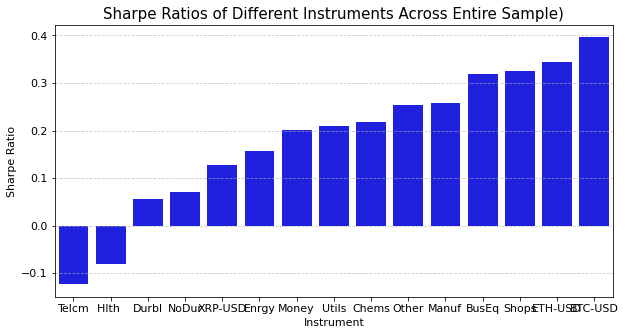

<Figure size 432x288 with 0 Axes>

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

data = {'Sharpe Ratio': industry_SR}
df = pd.DataFrame(data)

# Plotting the temperature plot using seaborn
plt.figure(figsize=(10, 5))  # Adjust the size here
sns.barplot(x=df.index, y='Sharpe Ratio', data=df, color='b')
plt.title('Sharpe Ratios of Different Instruments Across Entire Sample)', fontsize=15)
plt.xlabel('Instrument', fontsize=11)
plt.ylabel('Sharpe Ratio', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
plt.savefig("../reports/figures/SR_Entire_Sample).png")

Paramaters and plot limits for 3 different market timeframes to facilitate reproducibility. The desired dates corresponding to different timeframes are to be inputed inside of the first cell in src\data\data_grabbing.ipynb.

- Equity bull market
    - Period: 2017-10-31 <--> 2021-12-1
    - 3-y T-bill rate = 1.9 %
    - *ax.set_xlim(left=0.0125, right=0.0155)*
    - *ax.set_ylim(bottom=0.155, top=0.3)*
- High vol equity market with large drawdowns
    - Period: 2021-12-1 <--> 2023-10-31
    - 3-y T-bill rate = 0.95 %
    - *ax.set_xlim(left=0.0075, right=0.025)* 
    - *ax.set_ylim(bottom=0.0, top=0.35)*
- Large sample encapsulating different equity market regimes 
    - Period: 2017-10-31 <--> 2023-10-31
    - 5-y T-bill rate = 2.15 %
    - *ax.set_xlim(left=0.0114, right=0.015)*
    - *ax.set_ylim(bottom=0.04, top=0.12)*

For better interpretability, we advise the reader to adjust the axis limits of plotted graphs in each of the three periods when plotting the frontiers & exporting the .png files which is to be done by inputing the code * inside the plot_ef function below.

Computing efficient froniters

In [95]:
def plot_ef(n_points, er, cov, er2, cov2):
    """
    Plots two multi-asset efficient frontiers on the same graph
    """
    # First efficient frontier
    weights = optimal_weights(n_points, er, cov)  # Assuming optimal_weights is implemented
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef1 = pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })

    # Second efficient frontier
    weights2 = optimal_weights(n_points, er2, cov2)  # Assuming optimal_weights is implemented
    rets2 = [portfolio_return(w, er2) for w in weights2]
    vols2 = [portfolio_vol(w, cov2) for w in weights2]
    ef2 = pd.DataFrame({
        "Returns": rets2,
        "Volatility": vols2
    })

    # Plotting both efficient frontiers on the same graph
    ax = ef1.plot.line(x="Volatility", y="Returns", style='.-', label='Industry portfolio without cryptocurrencies', color='b', marker='o', markersize=4)
    ef2.plot.line(x="Volatility", y="Returns", style='.-', ax=ax, label='Industry portfolio with cryptocurrencies', color='r', marker='s', markersize=4)
    
    ax.set_xlim(left=0.0114, right=0.015) #Adjust according to the desired timeframe
    ax.set_ylim(bottom=0.04, top=0.12) #Adjust according to the desired timeframe

    # Customize the plot as needed
    title_text = "Efficient Frontier Comparison\nDuring the Entire Available Sample\n(Timeframe: 2017-10-31 - 2023-10-31)"
    plt.title("\n".join(textwrap.wrap(title_text, width=30)), fontsize=15) 
    plt.xlabel("Volatility", fontsize=12)
    plt.ylabel("Returns", fontsize=11)
    plt.legend(fontsize=12)
    plt.grid(True)
    
    plt.savefig("../reports/figures/TEST-Efficient_Frontier_Comparison_Full_Sample).png")
    plt.show()
    

Plotting the mean-variance frontiers

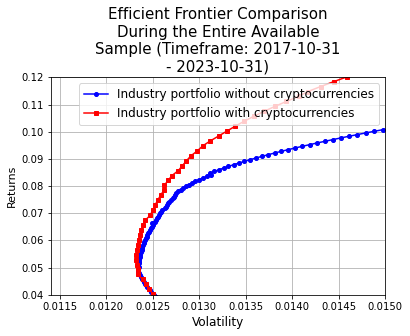

In [96]:
er = annualize_rets(ind_crypto, periods_per_year)
cov = ind_crypto.cov()
industry_crypto_combined_plots = plot_ef(201, er[industry], cov.loc[industry, industry], er[industry_and_crypto], cov.loc[industry_and_crypto, industry_and_crypto]) 

# trying some stuff for widgets

In [275]:
er = annualize_rets(ind_crypto, periods_per_year)
cov = ind_crypto.cov()

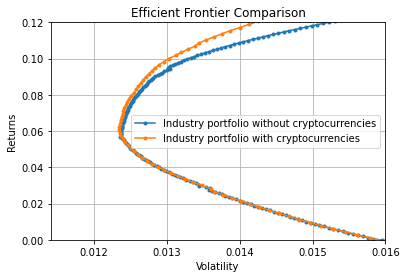

In [95]:
er1 = er[industry]
cov1 = cov.loc[industry, industry]
er2 = er[industry_and_crypto]
cov2 = cov.loc[industry_and_crypto, industry_and_crypto]
n_points = 200

# First efficient frontier
weights1 = optimal_weights(n_points, er1, cov1)  # Assuming optimal_weights is implemented
rets1 = [portfolio_return(w, er1) for w in weights]
vols1 = [portfolio_vol(w, cov1) for w in weights]
ef1 = pd.DataFrame({
        "Returns": rets1,
        "Volatility": vols1
    })

# Second efficient frontier
weights2 = optimal_weights(n_points, er2, cov2)  # Assuming optimal_weights is implemented
rets2 = [portfolio_return(w, er2) for w in weights2]
vols2 = [portfolio_vol(w, cov2) for w in weights2]
ef2 = pd.DataFrame({
    "Returns": rets2,
    "Volatility": vols2
})

# Plotting both efficient frontiers on the same graph
ax = ef1.plot.line(x="Volatility", y="Returns", style='.-', label='Industry portfolio without cryptocurrencies')
ef2.plot.line(x="Volatility", y="Returns", style='.-', ax=ax, label='Industry portfolio with cryptocurrencies')
    
ax.set_xlim(left=0.0114, right=0.016)
ax.set_ylim(bottom=0.0, top=0.12)

# Customize the plot as needed
plt.title("Efficient Frontier Comparison")
plt.xlabel("Volatility")
plt.ylabel("Returns")
plt.legend()
plt.grid(True)
    
plt.savefig("../reports/figures/figure1.png")
plt.show()

In [92]:
ef2

,Returns,Volatility
0,-0.004197,0.016447
1,-0.002488,0.016156
2,-0.000779,0.015984
3,0.000929,0.015788
4,0.002638,0.015615
...,...,...
195,0.329005,0.056454
196,0.330714,0.056989
197,0.332423,0.057532
198,0.334131,0.058084


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

# Example DataFrame with returns
# Replace this with your actual DataFrame
data = {
    'Date': ['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05'],
    'Portfolio1': [0.02, 0.01, -0.015, 0.03, -0.01],
    'Portfolio2': [0.015, 0.02, -0.01, 0.025, -0.02],
    'Portfolio3': [-0.01, 0.03, -0.02, 0.015, 0.01]
}

df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Function to plot scatter plot
def plot_scatter(start_date, end_date):
    selected_data = df.loc[start_date:end_date]
    
    plt.figure(figsize=(10, 6))
    for column in selected_data.columns:
        plt.scatter(selected_data.index, selected_data[column], label=column)

    plt.title('Portfolio Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()

# Create widgets for date selection
start_date_widget = widgets.DatePicker(description='Start Date', value=df.index.min())
end_date_widget = widgets.DatePicker(description='End Date', value=df.index.max())

# Create interactive plot
interact(plot_scatter, start_date=start_date_widget, end_date=end_date_widget)


interactive(children=(DatePicker(value=Timestamp('2023-01-01 00:00:00'), description='Start Date'), DatePicker…

<function __main__.plot_scatter(start_date, end_date)>